# Song lyrics exploration - Part 2: Lexical diversity

This part explores the [lexical diversity](https://en.wikipedia.org/wiki/Lexical_diversity) of different metal genres and bands. A few different methods are used to quantify lexical diversity in order to answer the question of which genre or band has the most complex vocabulary.

In [218]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.style.use('seaborn')
import seaborn as sns
sns.set(font_scale=2)
from nltk.corpus import words as nltk_words
from scipy.optimize import curve_fit
from scipy.stats import hypergeom

from nlp import tokenize

# Loading and pre-processing data

In [219]:
def get_genres(data):
    columns = [col for col in data.columns if 'genre_' in col]
    genres = [re.sub(r"^genre\_", "", col) for col in columns]
    return genres, columns


def get_bands(data):
    genres, genre_cols = get_genres(data)
    # Combine songs from same band
    band_genres = data.groupby('band_name')[genre_cols].max()
    band_lyrics = data.groupby('band_name').song_darklyrics.sum()
    bands = pd.concat((band_genres, band_lyrics), axis=1)
    bands.columns = genres + ['lyrics']
    bands['words'] = bands.lyrics.apply(tokenize)
    return bands


def get_songs(data):
    genres, genre_cols = get_genres(data)
    songs = data[['band_name', 'song_name'] + genre_cols + ['song_darklyrics']].copy()
    songs.columns = ['band_name', 'song_name'] + genres + ['lyrics']
    songs['words'] = songs.lyrics.apply(tokenize)
    return songs

In [220]:
df = pd.read_csv('songs-10pct.csv')
df_bands = get_bands(df)
df_songs = get_songs(df)

In [221]:
len(df_bands), len(df_songs)

(1352, 57878)

# Lexical diversity measures

One simple approach to quantifying lexical diversity is to divide the number of unique words (types, $V$) by the total word count (tokens, $N$). This type-token ratio or TTR is heavily biased toward short texts, since longer texts are more likely to repeat tokens without necessarily diminishing complexity. A few ways exist for rescaling the relationship to reduce this bias; for this notebook the root-TTR and log-TTR are used:

$$
\begin{split}
&LD_{TTR} &= \frac{V}{N} &\hspace{1cm} (\textrm{type-token ratio})\\
&LD_{rootTTR} &= \frac{V}{\sqrt{N}} &\hspace{1cm} (\textrm{root type-token ratio})\\
&LD_{logTTR} &= \frac{\log{V}}{\log{N}} &\hspace{1cm} (\textrm{logarithmic type-token ratio})\\
\end{split}
$$

### MTLD

More sophisticated approaches look at how types are distributed in the text. The bluntly named Measure of Textual Lexical Diversity (MTLD), described by [McCarthy and Jarvis (2010)](https://doi.org/10.3758/BRM.42.2.381), is based on the mean length of token sequences in the text that exceed a certain TTR threshold. The algorithm begins with a sequence consisting of the first token in the text, and iteratively adds the following token, each time recomputing the TTR of the sequence so far. Once the sequence TTR drops below the pre-determined threshold, the sequence ends and a new sequence begins at the next token. This continues until the end of the text is reached, at which point the mean sequence length is computed. The process is repeated from the last token, going backwards, to produce another mean sequence length. The mean of these two results is the final MTLD figure.

Unlike the simpler methods, MTLD has a tunable parameter. The TTR threshold is chosen by the authors to be 0.720, which is approximately where the cumulative TTR curves for texts in the Project Gutenburg Text Archives reached a point of stabilization. The same can be done with the DarkLyrics data by plotting cumulative TTR values for a large number of bands and identifying the point of stabilization. This cannot be done with single-song lyrics since refrains in the lyrics heavily warp the cumulative TTR curves, such that most never stabilize. Unfortunately even when looking at band lyrics, the cumulative TTR does not stabilize very well, as the curves seem to continue decaying well into the thousands of tokens. However one can roughly identify a point of stabilization somewhere around a TTR of 0.5, occuring at about 200 tokens, so this is used as the threshold for MTLD.

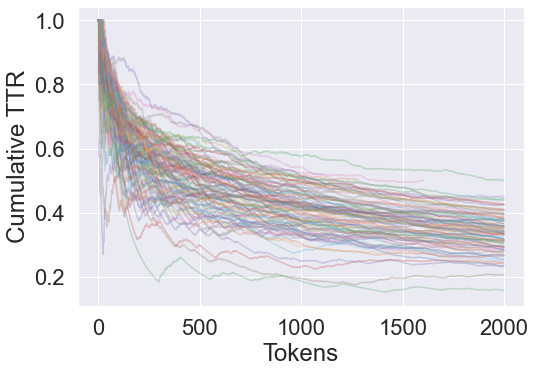

In [223]:
def TTR(x):
    return len(set(x)) / len(x)

def cumulative_TTR(words):
    out = [TTR(words[: i + 1]) for i in range(len(words))]
    return out

for i in range(0, 1000, 10):
    plt.plot(cumulative_TTR(df_bands.iloc[i].words[:2000]), alpha=0.3)
plt.xlabel('Tokens')
plt.ylabel('Cumulative TTR')
plt.show()

In [222]:
def MTLD_forward(words, threshold):
    factor = 0
    segment = []
    i = 0
    while i < len(words):
        segment.append(words[i])
        segTTR = TTR(segment)
        if segTTR <= threshold:
            segment = []
            factor += 1
        i += 1
    if len(segment) > 0:
        factor += (1.0 - segTTR) / (1.0 - threshold)
    factor = max(1.0, factor)
    mtld = len(words) / factor
    return mtld


def MTLD(words, threshold=0.720):
    if len(words) == 0:
        return 0.0
    forward = MTLD_forward(words, threshold)
    reverse = MTLD_forward(words[::-1], threshold)
    return 0.5 * (forward + reverse)

### vocd-D

The *vocd-D* method devised by [Malvern *et al.* (2004)](https://www.palgrave.com/gp/book/9781403902313) computes the mean TTR across 100 samples of lengths 35, 36, ... 49, 50. A function is fit to the resulting TTR vs. sample size data and the extracted best fit parameter $D$ is the lexical diversity index. Since this is a sampling-based method, the routine is done three times and the average of the $D$ values is output. I did not have access to Malvern *et al.* (2004) but did find the relevant function to fit from a [publicly viewable implementation](https://metacpan.org/release/Lingua-Diversity/source/lib/Lingua/Diversity/VOCD.pm) that is cited on a [Text Inspector page](https://textinspector.com/help/lexical-diversity).

$$f_{vocd}(N_s) = \frac{D}{N_s} \left( \sqrt{1 + 2 \frac{N_s}{D}} - 1 \right) \label{vocd-D}\tag{1}$$

where $N_s$ is the sample size. The higher the value of $D$, the more diverse the text.

### HD-D

[McCarthy and Jarvis (2007)](https://doi.org/10.1177%2F0265532207080767) showed that *vocd-D* was merely approximating a result that could directly be computed from the [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution). They developed an alternate implementation *HD-D* that computes the mean TTR for each sample size by summing the contribution of each type in the text to the overall mean TTR. The contribution of a type $t$ for a given sample size $N_s$ is equal to the product of that type's TTR contribution ($1/N_s$) and the probability of finding at least one instance of type $t$ in any sample. This probability is one minus the probability of finding exactly zero instances of $t$ in any sample, which can be computed by the hypergeometric distribution $P_t(k_t=0, N, n_t, N_s)$, where $k_t$ is the number of instances of type $t$, $N$ is still the number of tokens in the text, and $n_t$ is the number of occurences of $t$ in the full text (the order of arguments here is chosen to match the input of [`scipy.stats.hypergeom`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html) rather than the example in McCarthy and Jarvis (2007)). Thus, in summary, the goal is to compute

$$ f_{HD}(N_s) = \frac{1}{N_s} \sum_{t=1}^{V} 1 - P_t(0, N, n_t, N_s) \label{HD-D}\tag{2}$$

and either equate this to the Eq. \ref{vocd-D} above and [solve](https://www.symbolab.com/solver/function-inverse-calculator/inverse%20f%5Cleft(x%5Cright)%3Dx%5Cleft(%5Csqrt%7B%5Cleft(1%2B%5Cfrac%7B2%7D%7Bx%7D%5Cright)%7D-1%5Cright)) for $D$:

$$ D(N_s) = -\frac{\left[f_{HD}(N_s)\right]^2}{2\left[f_{HD}(N_s)-1\right]} $$

where $x$ is the output of Eq. \ref{HD-D}. The average across all sample sizes gives the value of $D$ for the *HD-D* method. Alternatively one can instead fit Eq. \ref{vocd-D} to the output of Eq. \ref{HD-D} to determine $D$.


### *vocd-D* or *HD-D*?

Although *vocd-D* merely approximates the result of *HD-D*, the latter is much slower, taking several seconds to produce *D* for a single artist's lyrics. The approximate method is still fairly accurate (within <1% away from the *HD-D* result in the example case) with just three trials, so it is the preferred method used in the rest of the notebook.

103.58275071308137


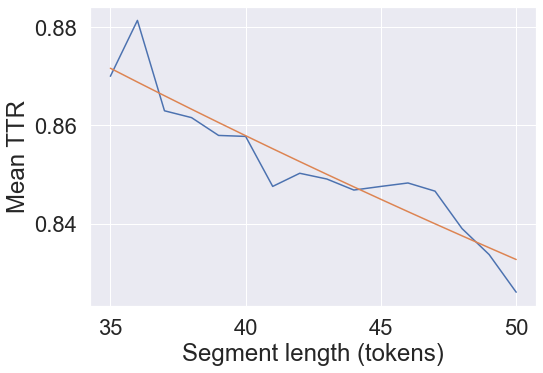

In [224]:
# Example of one vocd-D trial for a single artist

words = df_bands.loc['A Canorous Quintet'].words
num_segs = 100
seglen_range = range(35, 51)
ttrs = np.zeros((len(seglen_range), num_segs))
for i, seglen in enumerate(seglen_range):
    for j in range(num_segs):
        sample = random.sample(words, seglen)
        ttrs[i, j] = TTR(sample)
avg_ttrs_vocdD = ttrs.mean(1)
curve = lambda x, D: (D / x) * (np.sqrt(1 + 2 * (x / D)) - 1)
(D_vocdD,), _ = curve_fit(curve, seglen_range, avg_ttrs_vocdD)
print(D_vocdD)

plt.plot(seglen_range, avg_ttrs_vocdD)
plt.plot(seglen_range, curve(seglen_range, D_vocdD))
plt.xlabel('Segment length (tokens)')
plt.ylabel('Mean TTR')
plt.show()

In [225]:
# vocd-D implementation and example D values

def vocdD_curve(x, D):
    return (D / x) * (np.sqrt(1 + 2 * (x / D)) - 1)

def vocdD(words, num_trials=3, num_segs=100, min_seg=35, max_seg=50):
    if max_seg > len(words):
        return np.nan
    D_trials = []
    seglen_range = range(min_seg, max_seg + 1)
    for _ in range(num_trials):
        ttrs = np.zeros((len(seglen_range), num_segs))
        for i, seglen in enumerate(seglen_range):
            for j in range(num_segs):
                sample = random.sample(words, seglen)
                ttrs[i, j] = TTR(sample)
        avg_ttrs = ttrs.mean(1)
        (D_trial,), _ = curve_fit(vocdD_curve, seglen_range, avg_ttrs)
        D_trials.append(D_trial)
    return np.mean(D_trials)

print(vocdD(df_bands.loc['A Canorous Quintet'].words))
print(vocdD(df_bands.loc['Bal-Sagoth'].words))
print(vocdD(df_bands.loc['Dalriada'].words))

107.24246453948517
100.87182576210539
201.867083419284


107.01527500420107
107.11834112312057


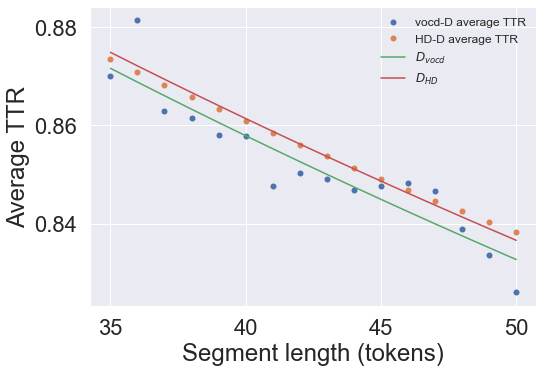

In [239]:
# Example of HD-D for a single artist and comparison to vocd-D

N = len(words)
types = {t: words.count(t) for t in set(words)}
seglen_range_HDD = range(35, 51)
avg_ttrs_HDD = np.zeros(len(seglen_range_HDD))
for s, N_s in enumerate(seglen_range_HDD):
    avg_ttr = 0
    for t, n_t in types.items():
        P_t = hypergeom(N, n_t, N_s).pmf(0)
        avg_ttr += (1 - P_t) / float(N_s)
    avg_ttrs_HDD[s] = avg_ttr
    D_HDDs[s] = -N_s * avg_ttr ** 2 / (2 * (avg_ttr - 1))
D_HDD1 = D_HDDs.mean()
print(D_HDD1)
(D_HDD2,), _ = curve_fit(vocdD_curve, seglen_range, avg_ttrs_HDD)
print(D_HDD2)

plt.plot(seglen_range, avg_ttrs_vocdD, 'o', label='vocd-D average TTR')
plt.plot(seglen_range, avg_ttrs_HDD, 'o', label='HD-D average TTR')
plt.plot(seglen_range, vocdD_curve(seglen_range, D_vocdD), label='$D_{vocd}$')
plt.plot(seglen_range, vocdD_curve(seglen_range, np.mean([D_HDD1, D_HDD2])), label='$D_{HD}$')
plt.xlabel('Segment length (tokens)')
plt.ylabel('Average TTR')
plt.legend(fontsize=12)
plt.show()

In [240]:
def get_lexical_diversity(data):
    N = data.words.apply(len)
    V = data.words.apply(lambda x: len(set(x)))
    data['N'] = N
    data['V'] = V
    data['TTR'] = V / N
    data['rootTTR'] = V / np.sqrt(N)
    data['logTTR'] = np.log(V) / np.log(N)
    data['mtld'] = data.words.apply(MTLD, threshold=0.5)
    data['logmtld'] = np.log(data['mtld'])
    data['vocdd'] = data.words.apply(vocdD, num_segs=10)
    return data[data.N > 0]

In [241]:
df_bands = get_lexical_diversity(df_bands)
df_songs = get_lexical_diversity(df_songs)

# Histograms

In [242]:
def plot_histograms(data):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle("Lexical diversity of heavy metal artists", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    logNmin, logNmax = np.log10(data.N.min()), np.log10(data.N.max())
    logbins = np.logspace(logNmin, logNmax, 20)
    data.N.hist(bins=logbins, edgecolor='k', ax=ax)
    ax.set_xscale('log')
    ax.set_title("Vocabulary sizes")
    ax.set_xlabel("N (tokens)")
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(ScalarFormatter())

    ax = axes[1]
    data.TTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{TTR} = V/N}$")

    ax = axes[2]
    data.rootTTR.hist(bins=20, edgecolor='k', ax=ax)
    ax.set_title("Root type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{rootTTR}} = \sqrt{V/N}$")

    ax = axes[3]
    data.logTTR.hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel("$\mathrm{LD_{logTTR}} = \log V / \log N$")

    ax = axes[4]
    data.logmtld[data.logmtld > -np.inf].hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("Measure of Textual Lexical Diversity")
    ax.set_xlabel("$\log(\mathrm{MTLD})$")

    ax = axes[5]
    data.vocdd[~data.vocdd.isnull()].hist(bins=30, edgecolor='k', ax=ax)
    ax.set_title("vocd-D")
    ax.set_xlabel("$D_{\mathrm{fit}}$")

    for ax in axes:
        ax.set_ylabel("Artists", rotation=0, labelpad=40)
        ax.grid(None)
        ax.grid(axis='y', color='k')

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

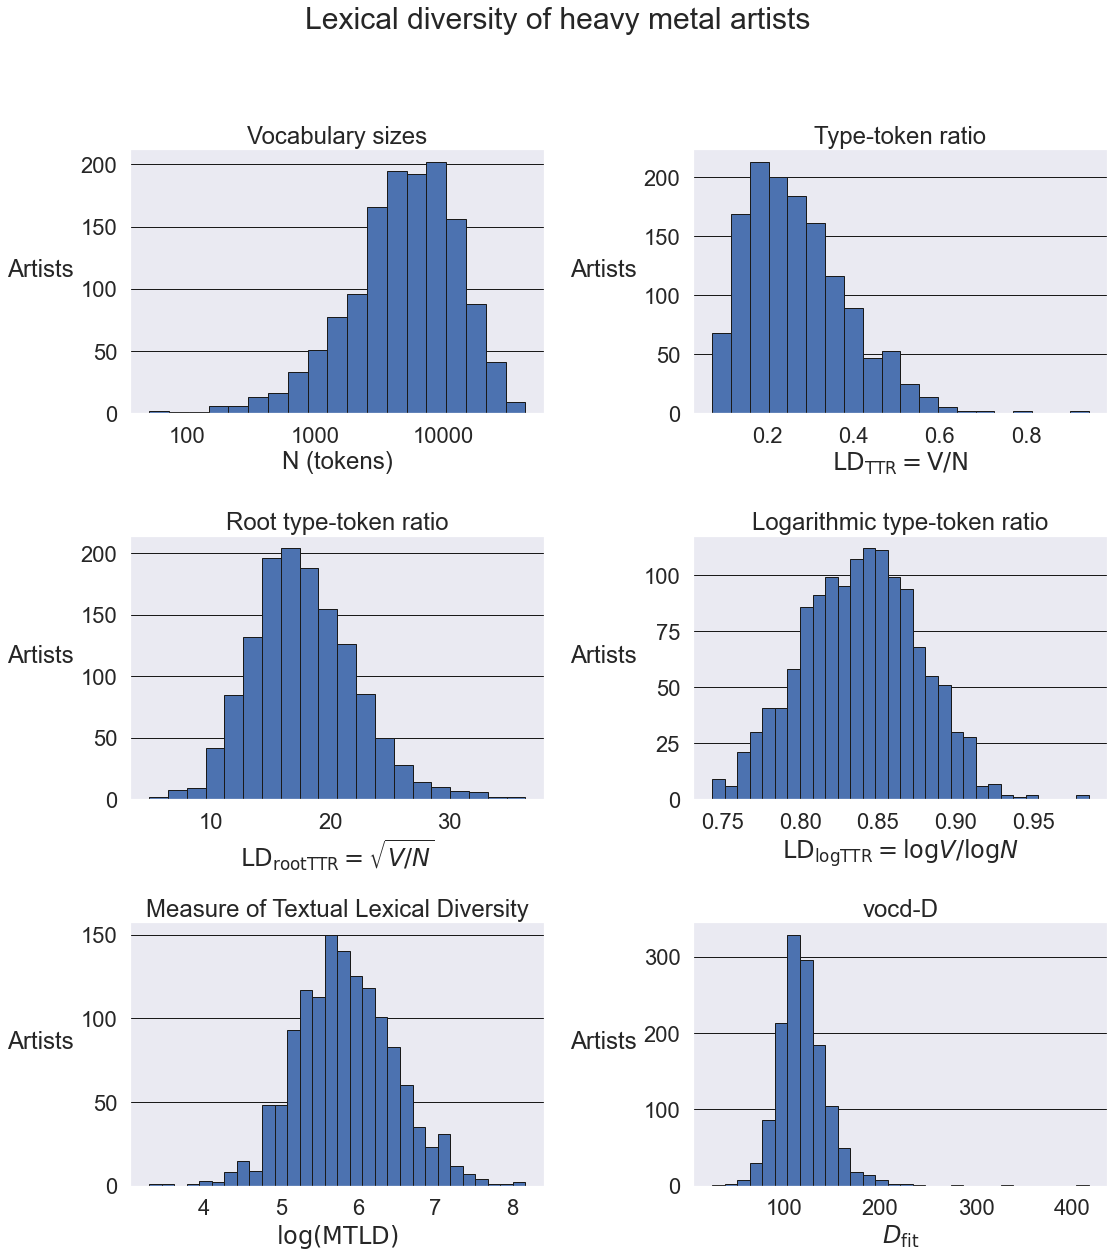

In [243]:
plot_histograms(df_bands)

# Violin plots

In [244]:
def plot_violinplots(data, figsize=(16, 18)):

    def violinplot(col, ax):
        violindata = []
        labels = data.columns[:list(data.columns).index('lyrics')]
        for label in labels:
            values = data[data[label] == 1][col]
            values = values[(values > -np.inf) & (values < np.inf)]
            violindata.append((label, values))
        violindata.sort(key=lambda x: -x[1].median())
        plot_labels, plot_data = zip(*violindata)
        sns.violinplot(data=plot_data, cut=0, orient='h', ax=ax, color='c')
        ax.set_yticklabels(plot_labels)
        return

    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
    axes = axes.flatten()

    ax = axes[0]
    violinplot('N', ax)
    ax.set_title("Word counts")
    ax.set_xlabel("N (tokens)")

    ax = axes[1]
    violinplot('V', ax)
    ax.set_title("Unique word counts")
    ax.set_xlabel("V (types)")

    ax = axes[2]
    violinplot('TTR', ax)
    ax.set_title("Type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{TTR}}$")

    ax = axes[3]
    violinplot('logTTR', ax)
    ax.set_title("Logarithmic type-token ratio")
    ax.set_xlabel(r"$\mathrm{LD_{logTTR}}$")

    ax = axes[4]
    violinplot('logmtld', ax)
    ax.set_title("Measure of Textual Lexical Diversity")
    ax.set_xlabel("$\log(\mathrm{MTLD})$")

    ax = axes[5]
    violinplot('vocdd', ax)
    ax.set_title("vocd-D")
    ax.set_xlabel("$D_{\mathrm{fit}}$")

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return

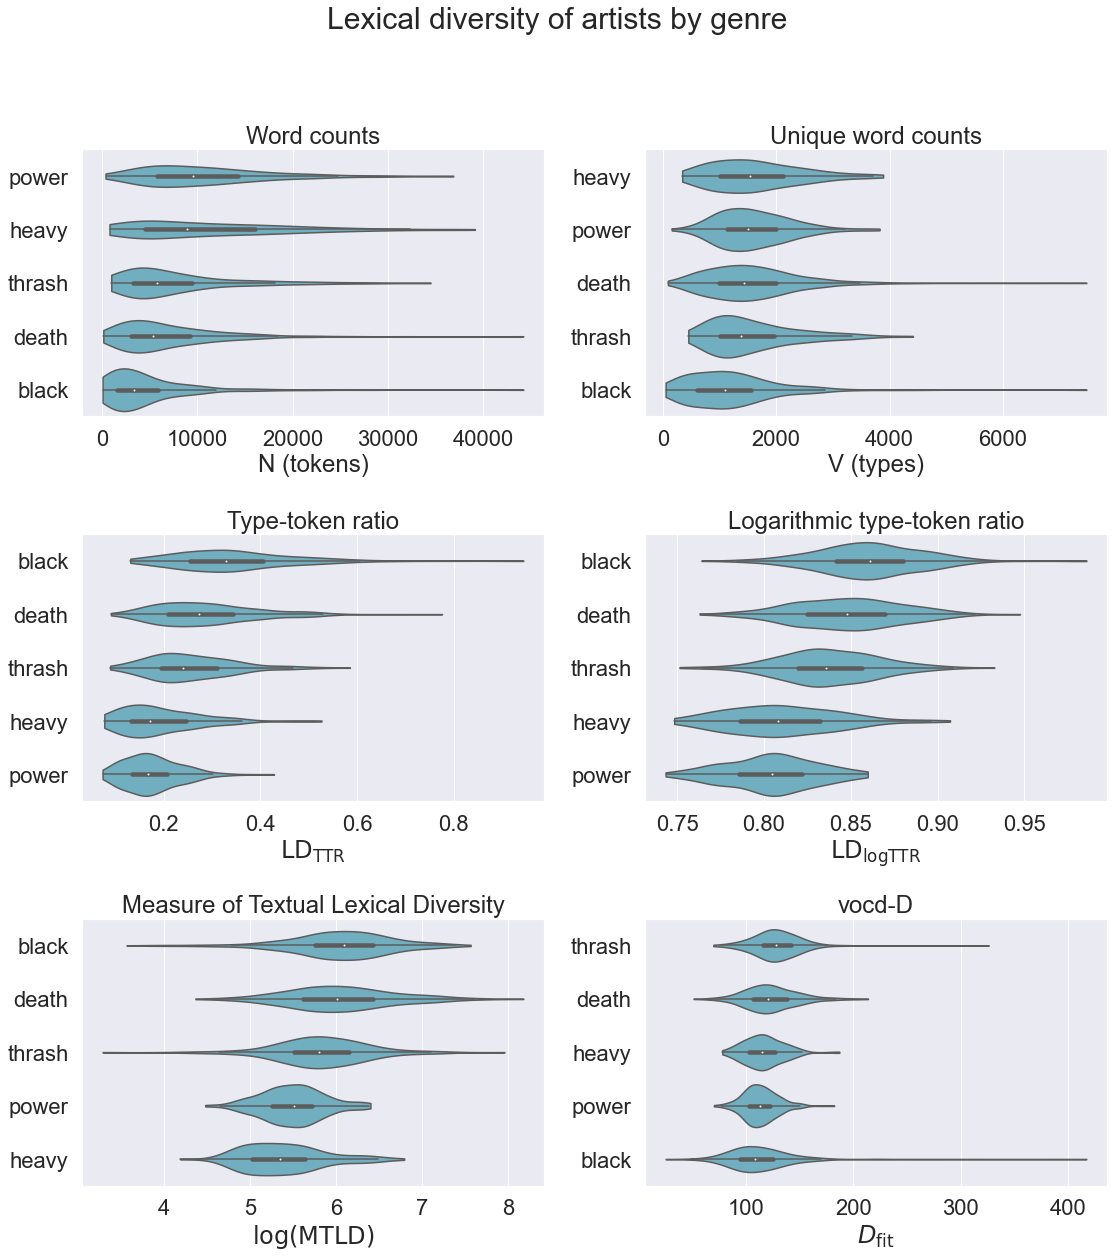

In [245]:
plot_violinplots(df_bands, figsize=(16, 18))

Several of the highest MTLD scores come from Bal-Sagoth songs. These are inflated as discussed in [Part 1](./lyrics0.ipnby): [Bal-Sagoth's lyrics](http://www.darklyrics.com/lyrics/balsagoth/thechthonicchronicles.html#4) consist of entire chapters of prose that are not actually sung in the songs themselves. Apart from this, The song with the highest MTLD is a 6-minute track by the Hungarian folk metal band Dalriada, [Zách Klára](http://www.darklyrics.com/lyrics/dalriada/aranyalbum.html#1).

In [246]:
df_songs.sort_values('mtld', ascending=False)[:20]

,band_name,song_name,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
5454,Bal-Sagoth,The Obsidian Crown Unbound,1,0,0,0,0,"\n\n\nFrom Sage Daelun's ""Chronicles of Antedi...","[from, sage, daelun, chronicles, of, antediluv...",2391,993,0.415307,20.307640,0.887044,914.286940,6.818144,83.885883
5453,Bal-Sagoth,Six Score and Ten Oblations to a Malefic Avatar,1,0,0,0,0,\n\n\n\nI have come into possession of a certa...,"[i, have, come, into, possession, of, a, certa...",840,453,0.539286,15.629985,0.908292,840.000000,6.733402,124.637643
53869,Ulver,Stone Angels,1,0,0,0,0,"\n\n\nAngels go - we\nmerely stray, image of\n...","[angels, go, -, we, merely, stray, image, of, ...",769,418,0.543563,15.073466,0.908262,769.000000,6.645091,161.498725
5425,Bal-Sagoth,Summoning the Guardians of the Astral Gate,1,0,0,0,0,\nIt is written in the ancient legends... that...,"[it, is, written, in, the, ancient, legends, t...",759,404,0.532279,14.664271,0.904918,759.000000,6.632002,87.850977
12441,Dalriada,Ágnes asszony (1. rész),0,0,0,0,0,\nÁgnes asszony a patakban\nFehér lepedőjét mo...,"[ágnes, asszony, a, patakban, fehér, lepedőjét...",744,393,0.528226,14.408079,0.903474,744.000000,6.612041,140.719093
5419,Bal-Sagoth,To Dethrone the Witch-Queen of Mytos K'unn (Th...,1,0,0,0,0,"\n\nThe vast armies of Mytos K'unn, marshalle...","[the, vast, armies, of, mytos, k'unn, marshall...",1413,621,0.439490,16.520399,0.886656,741.826206,6.609115,94.576875
5458,Bal-Sagoth,Unfettering the Hoary Sentinels of Karnak,1,0,0,0,0,\n\nWhen Blackthorne returns from his expediti...,"[when, blackthorne, returns, from, his, expedi...",1344,627,0.466518,17.102827,0.894153,730.723404,6.594035,87.696105
11364,Cradle of Filth,Beneath the Howling Stars,1,1,0,0,0,\nMidwinter wrongs the rites of Spring\nHer sp...,"[midwinter, wrongs, the, rites, of, spring, he...",706,426,0.603399,16.032721,0.922987,706.000000,6.559615,142.969732
5434,Bal-Sagoth,Blood Slakes the Sand at the Circus Maximus,1,0,0,0,0,\n\n\n\n\n Hearken! The Ninth Legion has been ...,"[hearken, the, ninth, legion, has, been, put, ...",1280,586,0.457813,16.379198,0.890798,701.022680,6.552540,104.042221
5433,Bal-Sagoth,When Rides the Scion of the Storms,1,0,0,0,0,\n\n\nHearken boy; for I would tell thee a tal...,"[hearken, boy, for, i, would, tell, thee, a, t...",669,341,0.509716,13.183822,0.896415,669.000000,6.505784,100.481100


In [247]:
df_songs.sort_values('vocdd', ascending=False)[:20]

,band_name,song_name,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
22717,Hail of Bullets,DAK,0,1,0,0,0,"\nA grave calamity, one Axis power retreats.\n...","[a, grave, calamity, one, axis, power, retreat...",54,54,1.000000,7.348469,1.000000,54.0,3.988984,787177.129136
9881,Cenotaph,Voluptuously Minced,0,1,0,0,0,"\nPulverizing the mouth of vagina, klitoral or...","[pulverizing, the, mouth, of, vagina, klitoral...",67,66,0.985075,8.063183,0.996424,67.0,4.204693,2140.864679
25790,Incantation,Invoked Infinity,0,1,0,0,0,\n\n\nDevoted I hold the dagger\ncarve the wil...,"[devoted, i, hold, the, dagger, carve, the, wi...",53,52,0.981132,7.142749,0.995202,53.0,3.970292,1320.655278
25817,Incantation,Ancients Arise,0,1,0,0,0,\nDescending peaks of Kur\nAbode of breathless...,"[descending, peaks, of, kur, abode, of, breath...",73,71,0.972603,8.309921,0.993525,73.0,4.290459,1148.252246
54944,Venom,All There Is Fear,1,0,0,0,0,\nArise young souls alight\nReclaim your satan...,"[arise, young, souls, alight, reclaim, your, s...",78,75,0.961538,8.492078,0.990998,78.0,4.356709,1049.107822
39687,Pessimist,Psychological Autopsy,1,1,0,0,0,\nVoices within... haunting viciously cowering...,"[voices, within, haunting, viciously, cowering...",88,84,0.954545,8.954430,0.989610,88.0,4.477337,864.587239
10500,Cianide,One-Thousand Ways to Die,0,1,0,0,0,\nDeath stalking helpless victims\nFeeding off...,"[death, stalking, helpless, victims, feeding, ...",97,92,0.948454,9.341185,0.988432,97.0,4.574711,826.712079
44730,Schizo,Mind K,1,0,0,0,1,\nFRONTLINE SEPARATION\r\nFREITOD BEHIND THE E...,"[frontline, separation, freitod, behind, the, ...",55,53,0.963636,7.146519,0.990757,55.0,4.007333,727.644324
4640,Autopsy,Ugliness and Secretions,0,1,0,0,0,"\nDrool dripping from your chin\nYellow eyes, ...","[drool, dripping, from, your, chin, yellow, ey...",55,53,0.963636,7.146519,0.990757,55.0,4.007333,724.018628
10514,Cianide,Forsaken Doom,0,1,0,0,0,\nEnd this pain mental torture inhumane\r\nDre...,"[end, this, pain, mental, torture, inhumane, d...",53,51,0.962264,7.005389,0.990311,53.0,3.970292,691.972925


The bottom of the chart is mostly populated by very short, usually one-word, songs. Of songs with at least ten words, the honor of least lyrically diverse song goes to none other than the magnificently linguistically efficient "Thunderhorse" by Dethklok, which consists of the words "ride", "thunder", "horse", "revenge", and of course "thunderhorse", uttered a total of 33 times altogether. Why say lot word when few do trick?

In [248]:
df_songs[df_songs.N > 10].sort_values('mtld', ascending=True)[:20]

,band_name,song_name,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
15075,Dethklok,Thunderhorse,0,1,0,0,0,\nRide...\nRide...\nRide...\nRide...\n\nThunde...,"[ride, ride, ride, ride, thunder, thunder, thu...",33,5,0.151515,0.870388,0.460299,2.952632,1.082697,NaN
41040,Putrid Pile,Toxic Shock Therapy,0,1,0,0,0,\nBe be oh be be be oh be be be\nOh be ah ah a...,"[be, be, oh, be, be, be, oh, be, be, be, oh, b...",18,3,0.166667,0.707107,0.380094,3.300000,1.193922,NaN
5243,Axxis,Journey to Utopia,0,0,1,1,0,"\n\n\nHey, hey, hey Utopia\nHey, hey, hey Utop...","[hey, hey, hey, utopia, hey, hey, hey, utopia,...",15,2,0.133333,0.516398,0.255958,3.750000,1.321756,NaN
28036,Katatonia,Dancing December,0,1,0,0,0,\nDance away...\nDance away...\nDance away...\...,"[dance, away, dance, away, dance, away, dance,...",12,2,0.166667,0.577350,0.278943,4.000000,1.386294,NaN
30465,Lost Society,Fatal Anoxia,0,0,0,0,1,\nFATAL ANOXIA\r\nFATAL ANOXIA\r\nFATAL ANOXIA...,"[fatal, anoxia, fatal, anoxia, fatal, anoxia, ...",15,2,0.133333,0.516398,0.255958,4.090909,1.408767,NaN
30797,M.O.D.,Bubble Butt,0,0,0,0,1,\nBubble Butt\r\nBubble Butt\r\nBubble Butt\r\...,"[bubble, butt, bubble, butt, bubble, butt, bub...",25,5,0.200000,1.000000,0.500000,4.166667,1.427116,NaN
13285,Dawnbringer,Scream and Run,1,0,1,0,0,\nScream and run\nScream and run\nScream and r...,"[scream, and, run, scream, and, run, scream, a...",51,3,0.058824,0.420084,0.279415,5.435374,1.692928,0.116468
50790,The Great Kat,Metal Messiah,0,0,0,0,1,\nI'm your savior\nI'm your God\nWE SHALL OVER...,"[i'm, your, savior, i'm, your, god, we, shall,...",83,20,0.240964,2.195285,0.677945,6.545110,1.878718,3.118799
16450,Dornenreich,Im Fluss die Flammen,1,0,0,0,0,\nDein Mut ist dein Vertrauen\nDein Vertrauen ...,"[dein, mut, ist, dein, vertrauen, dein, vertra...",72,20,0.277778,2.357023,0.700483,6.872727,1.927561,6.140816
15976,Discharge,Free Speech for the Dumb,0,0,1,0,1,\nFree speech free speech for the dumb \nFree ...,"[free, speech, free, speech, for, the, dumb, f...",14,5,0.357143,1.336306,0.609853,7.000000,1.945910,NaN


In [249]:
df_songs.sort_values('vocdd', ascending=True)[:20]

,band_name,song_name,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
13285,Dawnbringer,Scream and Run,1,0,1,0,0,\nScream and run\nScream and run\nScream and r...,"[scream, and, run, scream, and, run, scream, a...",51,3,0.058824,0.420084,0.279415,5.435374,1.692928,0.116468
53567,Type O Negative,Set Me on Fire,0,0,0,0,0,\nSummer girl.\nSummer girl.\nSummer girl.\nSu...,"[summer, girl, summer, girl, summer, girl, sum...",72,7,0.097222,0.824958,0.455006,9.142857,2.212973,0.699421
37382,Nuit Noire,I Am a Fairy,1,0,0,0,0,\nI am a fairy! I am a fairy! I am a fairy! I....,"[i, am, a, fairy, i, am, a, fairy, i, am, a, f...",150,16,0.106667,1.306395,0.553341,10.144124,2.316895,1.180197
34622,Mortiis,Thieving Bastards,0,0,0,0,0,\nIt´s all coming down \rIt´s all coming down ...,"[it, s, all, coming, down, it, s, all, coming,...",56,9,0.160714,1.202676,0.545847,9.333333,2.233592,1.234491
3143,Anthrax,604,0,0,0,0,1,\nCan't stop eating\nCan't stop eating\nCan't ...,"[can't, stop, eating, can't, stop, eating, can...",52,10,0.192308,1.386750,0.582749,13.000000,2.564949,1.310010
54852,Vendetta,Love Song,0,0,0,0,1,\nWe hope that you love - as I - as we do\nWe ...,"[we, hope, that, you, love, -, as, i, -, as, w...",55,10,0.181818,1.348400,0.574593,18.516667,2.918671,1.496761
15227,Devin Townsend,Unity,0,0,0,0,0,"\n\n\nLife, it's all life\nIt's all alive\nIt'...","[life, it, all, life, it, all, alive, it, alri...",77,12,0.155844,1.367527,0.572058,8.697821,2.163073,1.540828
50797,The Great Kat,Kill the Mothers,0,0,0,0,1,\nKILL! KILL! KILL! KILL!\nKILL! KILL! KILL! K...,"[kill, kill, kill, kill, kill, kill, kill, kil...",199,22,0.110553,1.559539,0.583953,7.116220,1.962377,1.567913
27140,Jesu,Walk on Water,0,0,0,0,0,\n\nBe there for your summer.\nBe dead by the ...,"[be, there, for, your, summer, be, dead, by, t...",90,12,0.133333,1.264911,0.552225,17.437500,2.858623,1.951987
48850,Suicidal Tendencies,Public Dissension,0,0,0,0,1,\n\n\nPublic dissension!\nPublic dissension!\n...,"[public, dissension, public, dissension, publi...",217,16,0.073733,1.086151,0.515361,9.105340,2.208861,2.079258


In [250]:
df_bands.sort_values('mtld', ascending=False)[:20]

,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
band_name,,,,,,,,,,,,,,,
Hail of Bullets,0,1,0,0,0,\nHear the engines roaring\nHear the grinding ...,"[hear, the, engines, roaring, hear, the, grind...",3544,1867,0.526806,31.361546,0.921581,3544.000000,8.173011,197.655721
Malignancy,0,1,0,0,0,\nFrom vaginal sores seep fetid secretions \r\...,"[from, vaginal, sores, seep, fetid, secretions...",5530,2094,0.378662,28.158798,0.887315,3110.126557,8.042419,204.910068
Demolition Hammer,0,0,0,0,1,\nProgressive evolution\nSpawns a hybrid breed...,"[progressive, evolution, spawns, a, hybrid, br...",2845,1665,0.585237,31.215702,0.932640,2845.000000,7.953318,326.072742
Abnormality,0,1,0,0,0,\nInnocence. Intervals I cannot recall\r\nElim...,"[innocence, intervals, i, cannot, recall, elim...",2443,1235,0.505526,24.986488,0.912555,2443.000000,7.800982,147.388896
Brutality,0,1,0,0,0,\n\n\n\nTomb of desecration\nSadistic land ete...,"[tomb, of, desecration, sadistic, land, eterna...",3535,1663,0.470438,27.970327,0.907705,2106.258186,7.652668,193.086132
Wormed,0,1,0,0,0,\nExpulsion\r\nAbstract vector space\r\nElectr...,"[expulsion, abstract, vector, space, electrons...",2007,1103,0.549576,24.620781,0.921281,2007.000000,7.604396,199.844172
Mortal Decay,0,1,0,0,0,"\nThe butchered remains of twelve cadavers, ha...","[the, butchered, remains, of, twelve, cadavers...",2257,1121,0.496677,23.596079,0.909371,1997.743094,7.599773,169.948344
Cormorant,1,1,0,0,0,"\nA million shells like stones in sand,\nThe s...","[a, million, shells, like, stones, in, sand, t...",5692,2295,0.403197,30.419372,0.894952,1922.694201,7.561483,122.976721
Impaled,0,1,0,0,0,\n\n\n\nDesiccated flesh I peruse \nYour vacuo...,"[desiccated, flesh, i, peruse, your, vacuous, ...",6706,2697,0.402177,32.934356,0.896619,1813.133826,7.502812,160.383069


In [256]:
df_bands.sort_values('vocdd', ascending=True)[:20]

,black,death,heavy,power,thrash,lyrics,words,N,V,TTR,rootTTR,logTTR,mtld,logmtld,vocdd
band_name,,,,,,,,,,,,,,,
Nokturnal Mortum,1,0,0,0,0,"\nHey, above the mountain, hey, above the vall...","[hey, above, the, mountain, hey, above, the, v...",372,92,0.247312,4.769978,0.763958,96.046552,4.564833,24.903934
Absurd,1,0,0,0,0,"\nWhite are the Wings of the Angels,\r\nwhite ...","[white, are, the, wings, of, the, angels, whit...",154,81,0.525974,6.527166,0.872442,103.931034,4.643728,44.485108
Vinterland,1,0,0,0,0,\nWith fury I feel the night appear within\nIn...,"[with, fury, i, feel, the, night, appear, with...",706,194,0.274788,7.301286,0.803074,77.903448,4.355470,48.779806
Crypt of Kerberos,0,1,0,0,0,"\nGod's of storm\r\non my kness I pray,\r\nspe...","[god, of, storm, on, my, kness, i, pray, spear...",166,87,0.524096,6.752510,0.873615,166.000000,5.111988,50.881734
October Falls,0,0,0,0,0,"\nThere's an absent of light, a hunger towards...","[there, an, absent, of, light, a, hunger, towa...",1896,581,0.306435,13.343107,0.843292,277.631295,5.626294,51.113853
Nuit Noire,1,0,0,0,0,\nI am happy in the forest because the night i...,"[i, am, happy, in, the, forest, because, the, ...",963,310,0.321911,9.989610,0.835011,55.389412,4.014388,52.840406
Maniac Butcher,1,0,0,0,0,\nFour black clouds\nOver Saaz\nFree barbarian...,"[four, black, clouds, over, saaz, free, barbar...",75,50,0.666667,5.773503,0.906088,75.000000,4.317488,58.739644
Earth,0,0,0,0,0,\nBones are feeling sleazy\r\nHead spinning ar...,"[bones, are, feeling, sleazy, head, spinning, ...",355,136,0.383099,7.218131,0.836607,161.286192,5.083180,58.903940
Interment,0,1,0,0,0,\nThe dead will arise \nLike an angel sent fro...,"[the, dead, will, arise, like, an, angel, sent...",217,99,0.456221,6.720558,0.854128,167.097561,5.118578,59.568929


# Scatter plots

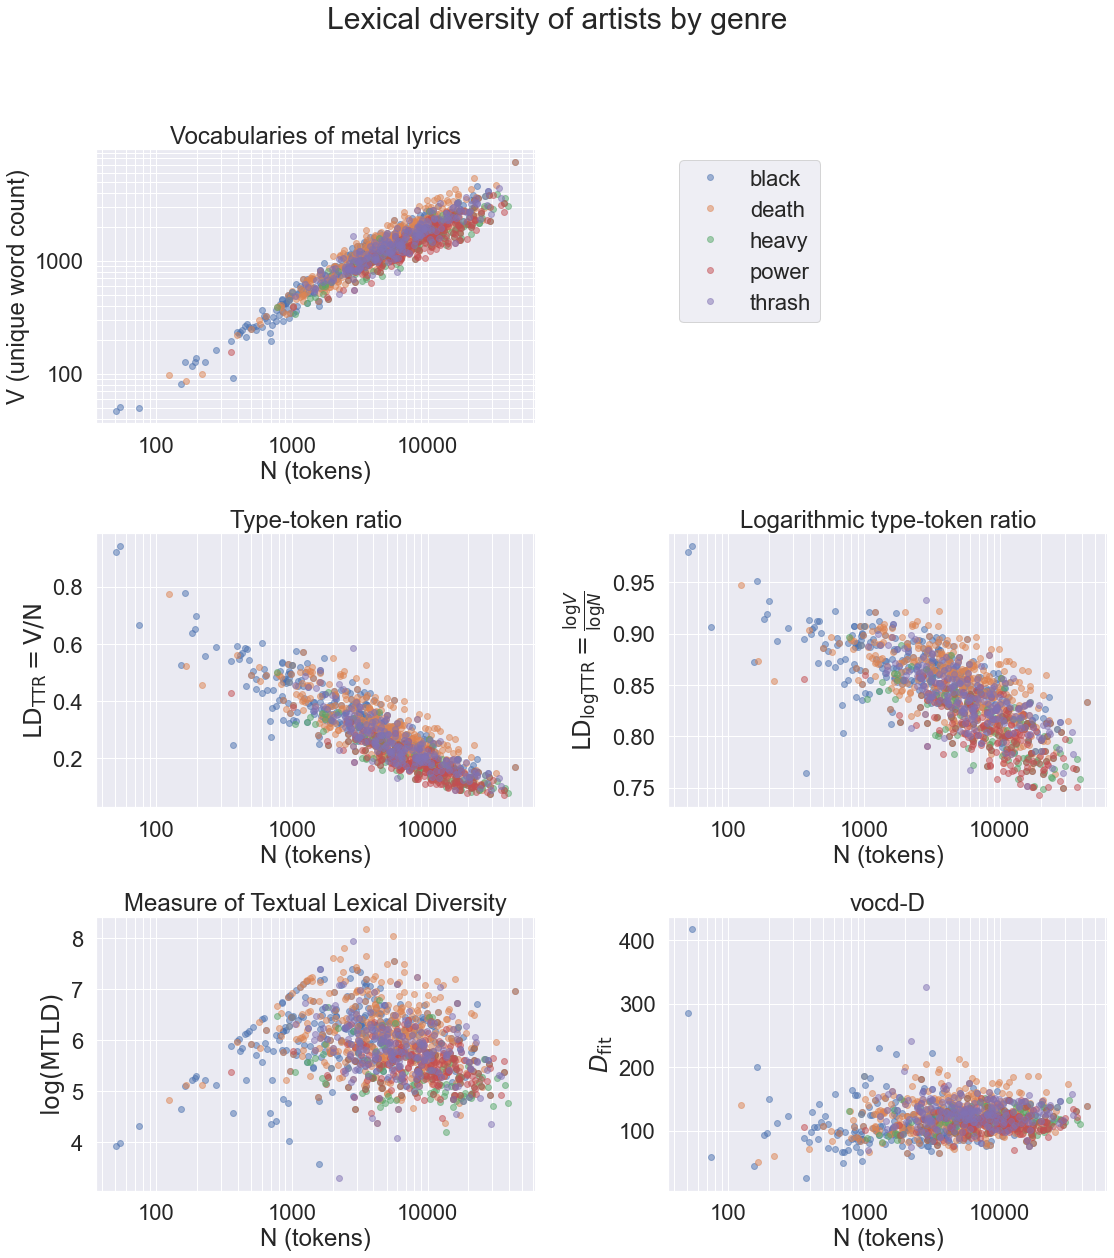

In [255]:
genres = df_bands.columns[:list(df_bands.columns).index('lyrics')]

def lexical_diversity_scatterplot(col, ax, logx=False, logy=False):
    for genre in genres:
        subset = df_bands[df_bands[genre] > 0]
        ax.plot(subset['N'], subset[col], 'o', markeredgewidth=1, alpha=0.5, label=genre)
    ax.set_xlabel("N (tokens)")
    if logx:
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(ScalarFormatter())
    if logy:
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.grid(True, axis='both', which='major')
    ax.grid(True, axis='both', which='minor')
    return

fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle("Lexical diversity of artists by genre", fontsize=30)
axes = axes.flatten()

ax = axes[0]
lexical_diversity_scatterplot('V', ax)
ax.set_xscale('log')
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.set_title("Vocabularies of metal lyrics")
ax.set_ylabel("V (unique word count)")

ax = axes[1]
ax.axis('off')
for genre in genres:
    ax.plot([], [], 'o', markeredgewidth=1, alpha=0.5, label=genre)
ax.legend(frameon=True, loc='upper left')

ax = axes[2]
lexical_diversity_scatterplot('TTR', ax, logx=True)
ax.set_title("Type-token ratio")
ax.set_ylabel("$\mathrm{LD_{TTR} = V/N}$")

ax = axes[3]
lexical_diversity_scatterplot('logTTR', ax, logx=True)
ax.set_title("Logarithmic type-token ratio")
ax.set_ylabel(r"$\mathrm{LD_{logTTR}} = \frac{\log V}{\log N}$")

ax = axes[4]
lexical_diversity_scatterplot('logmtld', ax, logx=True)
ax.set_title("Measure of Textual Lexical Diversity")
ax.set_ylabel(r"$\log(\mathrm{MTLD})$")

ax = axes[5]
lexical_diversity_scatterplot('vocdd', ax, logx=True)
ax.set_title("vocd-D")
ax.set_ylabel(r"$D_{\mathrm{fit}}$")

fig.tight_layout(rect=[0, 0, 1, 0.95])

# Violin plots with expanded genres dataset

In [253]:
df_exp = pd.read_csv('songs-1pct.csv')
df_exp_bands = get_bands(df_exp)
df_exp_bands = get_lexical_diversity(df_exp_bands)

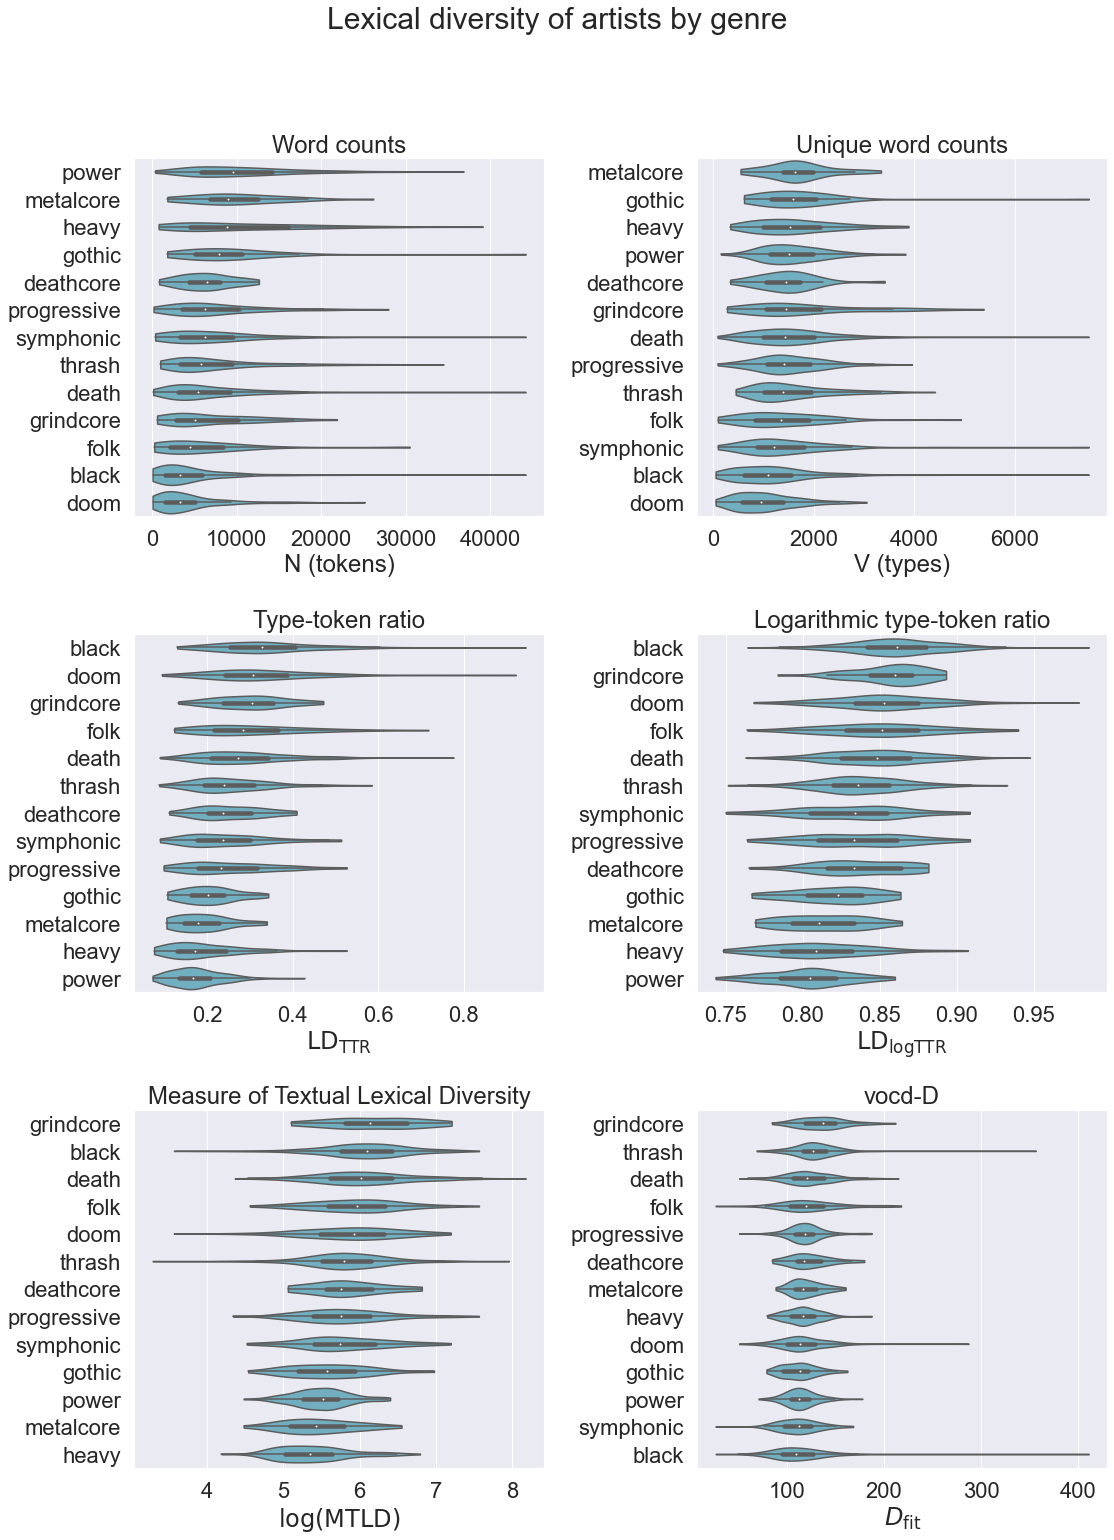

In [254]:
plot_violinplots(df_exp_bands, figsize=(16, 22))